<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Flights data time series analysis

In [1]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Aug2019_flights.csv':'https://storage.googleapis.com/aipi_datasets/Aug2019_flights.csv',
        'Airport_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airport_codes.csv',
        'Airline_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airline_codes.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

## Prepare the data
We will start by loading the necessary libraries and reading in the dataset to a pandas dataframe.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Read in the data and display the head to see what data we have
flight_data = pd.read_csv("Aug2019_flights.csv")
print(flight_data.dtypes)
flight_data.head()


DAY_OF_WEEK            int64
FL_DATE               object
OP_UNIQUE_CARRIER     object
OP_CARRIER_FL_NUM      int64
ORIGIN_AIRPORT_ID      int64
DEST_AIRPORT_ID        int64
CRS_DEP_TIME           int64
DEP_DELAY_NEW        float64
CANCELLED              int64
WEATHER_DELAY        float64
dtype: object


,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,WEATHER_DELAY
0,1,8/12/19,9E,5001,10397,10781,1050,0.0,0,NaN
1,1,8/19/19,9E,5001,10397,10781,1050,0.0,0,NaN
2,1,8/26/19,9E,5001,10397,10781,1050,0.0,0,NaN
3,1,8/5/19,9E,5001,10781,10397,1159,74.0,0,0.0
4,1,8/12/19,9E,5001,10781,10397,1159,0.0,0,NaN


In [3]:
# Convert FL_DATE to datetime
flight_data['FL_DATE'] = pd.to_datetime(flight_data['FL_DATE'])
print(flight_data.dtypes)

DAY_OF_WEEK                   int64
FL_DATE              datetime64[ns]
OP_UNIQUE_CARRIER            object
OP_CARRIER_FL_NUM             int64
ORIGIN_AIRPORT_ID             int64
DEST_AIRPORT_ID               int64
CRS_DEP_TIME                  int64
DEP_DELAY_NEW               float64
CANCELLED                     int64
WEATHER_DELAY               float64
dtype: object


We can add additional columns to store unique features of the data e.g. the year, month, day or hour

In [4]:
flight_data['DAY'] = flight_data['FL_DATE'].dt.day
flight_data['MONTH'] = flight_data['FL_DATE'].dt.month
flight_data.head()

,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,WEATHER_DELAY,DAY,MONTH
0,1,2019-08-12,9E,5001,10397,10781,1050,0.0,0,NaN,12,8
1,1,2019-08-19,9E,5001,10397,10781,1050,0.0,0,NaN,19,8
2,1,2019-08-26,9E,5001,10397,10781,1050,0.0,0,NaN,26,8
3,1,2019-08-05,9E,5001,10781,10397,1159,74.0,0,0.0,5,8
4,1,2019-08-12,9E,5001,10781,10397,1159,0.0,0,NaN,12,8


## Time series visualization
We will run a time series analysis on the number of flights per day over the month period.  Let's first visualize the trends

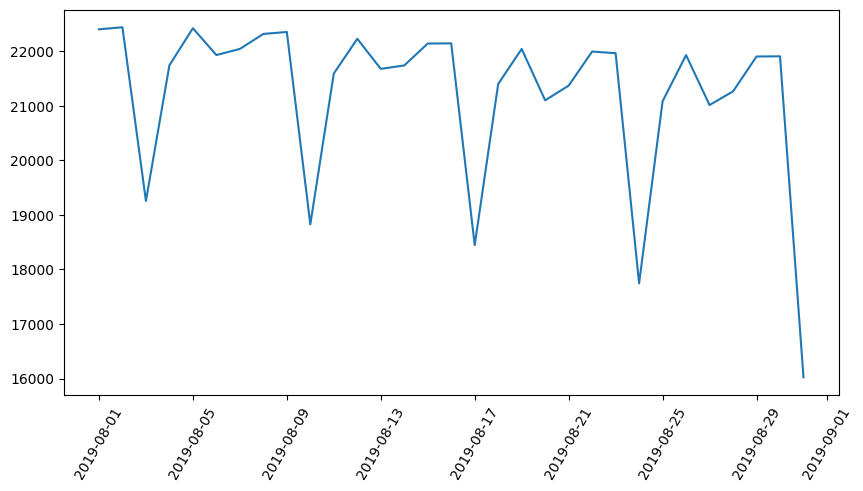

In [5]:
# Group flights by day of the month and count the number of flights each day
flights_per_day = flight_data['FL_DATE'].value_counts().sort_index(ascending=True)

# Plot the flights per day
plt.figure(figsize=(10,5))
plt.plot(flights_per_day)
plt.xticks(rotation=60)
plt.show()

## Time series decomposition
We can use the statsmodels library seasonal_decompose tool to break down our time series data into its components - trend and seasonality.  We first need to determine whether our data is better represented by an additive or multiplicative model.

An **additive model** is a linear model in which the components are added together.  The model assumes that seasonality is linear and therefore has the same frequency and amplitude over time.  
`y(t) = Trend + Seasonality + Noise`

A **multiplicative model** suggests the components are multiplied together and is therefore nonlinear.  The model assumes that seasonality is nonlinear and frequency and/or amplitude increase or decrease over time  
`y(t) = Trend * Seasonality * Noise`

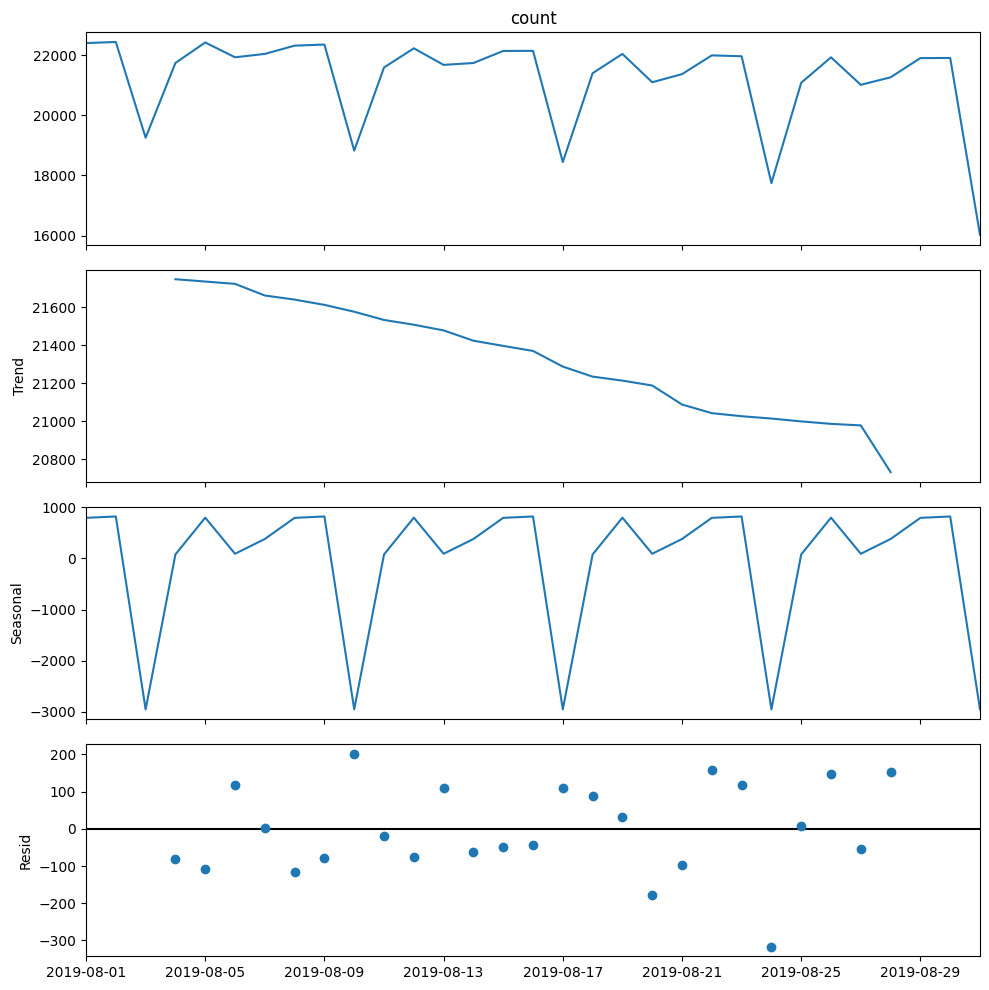

In [6]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(flights_per_day, model = 'additive',period=7) # Period =7 because seasonality is on weekly basis
plt.rcParams['figure.figsize'] = [10,10]
decomposition.plot()
plt.show()

By looking at the magnitude of the trend and seasonal components relative to the residuals, we determine that these modeled effects are not likely due to randomness and that there is in fact a trend component to our data and a seasonal/cyclical component with a period=7.

# Model the time series
## Model the trend

In [7]:
# To use the date as a feature for linear modeling, we need to convert it to numeric number of days since origin
linmodel_df = pd.DataFrame({'Count':flights_per_day})
linmodel_df['Days'] = (linmodel_df.index-linmodel_df.index.min()).days
linmodel_df.head()

,Count,Days
FL_DATE,,
2019-08-01,22403,0
2019-08-02,22440,1
2019-08-03,19256,2
2019-08-04,21743,3
2019-08-05,22423,4


Let's fit a linear regression on the data using only the day ('Day') as a single predictor variable.

In [8]:
# Create a single-variable linear regression and fit it to the data
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X=linmodel_df['Days'].values.reshape(-1,1), y=linmodel_df['Count'])

# Get in-sample predictions (on the training set) for the days in the month
linear_preds = linear_model.predict(linmodel_df['Days'].values.reshape(-1,1))

# Add predictions and residuals to the dataframe
linmodel_df['Preds'] = linear_preds
linmodel_df['resids']=linmodel_df['Count']-linmodel_df['Preds']

linmodel_df.head()

,Count,Days,Preds,resids
FL_DATE,,,,
2019-08-01,22403,0,22013.504032,389.495968
2019-08-02,22440,1,21961.982258,478.017742
2019-08-03,19256,2,21910.460484,-2654.460484
2019-08-04,21743,3,21858.938710,-115.938710
2019-08-05,22423,4,21807.416935,615.583065


Now we can calculate the error metrics of our model.  If these are new to you and do not follow how they are calculated, here is a simple introductory video: https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/assessing-the-fit-in-least-squares-regression/v/r-squared-or-coefficient-of-determination

Mean squared error (MSE):
$$ MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^{2} $$

Coefficient of determination (R-squared):
$$ R^2 = 1 − \frac{\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^{2}}{\sum_{i=1}^{n}(y_{i} - \bar{y}_{i})^{2}} = 1 - \frac{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y}_{i})^{2}}{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \bar{y}_{i})^{2}} = 1 - \frac{\sigma_{residuals}^{2}}{\sigma_{y}^{2}} = 1 - \frac{MSE}{\sigma_{y}^{2}}$$

The fitted model is: y = -51.522x + 22013.504
The simple linear model has R^2=0.092 and MSE=2089673.019


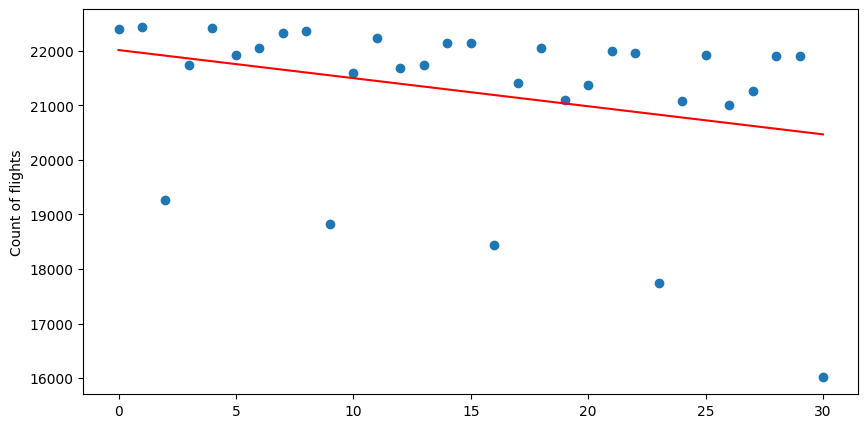

In [9]:
# Calculate the model performance statistics
mse = np.sum(linmodel_df['resids']**2,axis=0)/linmodel_df.shape[0]
r2 = 1 - np.sum((linmodel_df['resids'])**2)/np.sum((linmodel_df['Count']-np.mean(linmodel_df['Count']))**2)
#r2 = 1 - mse/np.var(linmodel_df['Count']) # Alternative way to calculate r2

# Display the model and performance metrics
print('The fitted model is: y = {:.3f}x + {:.3f}'.format(linear_model.coef_[0], linear_model.intercept_))
print('The simple linear model has R^2={:.3f} and MSE={:.3f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=linmodel_df['Days'], y=linmodel_df['Count'])
plt.plot(linmodel_df['Days'], linmodel_df['Preds'],color='red')
plt.ylabel('Count of flights')
plt.show()

## Model the weekly seasonality

In [10]:
# Add feature for day of week
dowmodel_df = pd.DataFrame({'Count':flights_per_day})
dowmodel_df['Day_of_week'] = dowmodel_df.index.dayofweek
dowmodel_df.head()

,Count,Day_of_week
FL_DATE,,
2019-08-01,22403,3
2019-08-02,22440,4
2019-08-03,19256,5
2019-08-04,21743,6
2019-08-05,22423,0


In [11]:
# Apply one-hot encoding to create a separate feature for each day of week
dowmodel_encoded = pd.get_dummies(data = dowmodel_df, columns=['Day_of_week'])
dowmodel_encoded.head()

,Count,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6
FL_DATE,,,,,,,,
2019-08-01,22403,False,False,False,True,False,False,False
2019-08-02,22440,False,False,False,False,True,False,False
2019-08-03,19256,False,False,False,False,False,True,False
2019-08-04,21743,False,False,False,False,False,False,True
2019-08-05,22423,True,False,False,False,False,False,False


The fitted model is:
y = 21288.79 + 867.46*Day_of_week_0 + 142.46*Day_of_week_1 + 315.71*Day_of_week_2 + 863.61*Day_of_week_3 + 873.61*Day_of_week_4 + -3228.79*Day_of_week_5 + 165.96*Day_of_week_6
The simple linear model has R^2=0.886 and MSE=263363.537


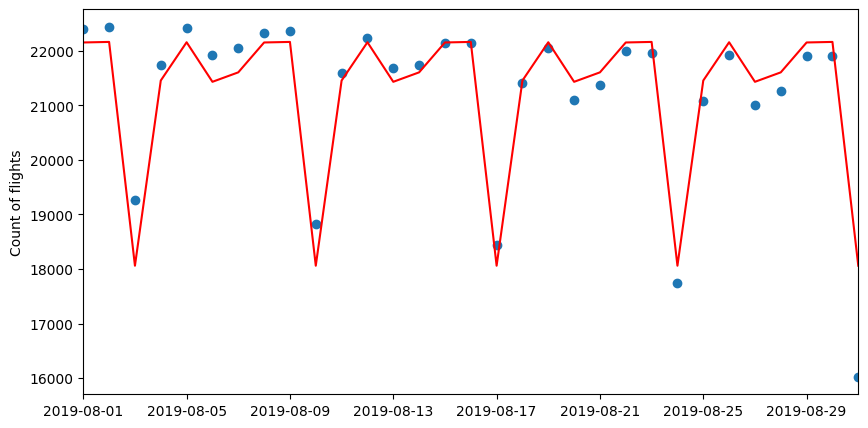

In [12]:
# Create a linear regression and fit it to the data
dow_model = LinearRegression()
X = dowmodel_encoded.drop(labels='Count',axis=1)
y = dowmodel_encoded['Count']
dow_model.fit(X, y)

# Get in-sample predictions (on the training set)
preds = dow_model.predict(X)

# Add predictions and residuals to the dataframe
dowmodel_encoded['Preds'] = preds
dowmodel_encoded['resids']=dowmodel_encoded['Count']-dowmodel_encoded['Preds']

# Calculate the model performance statistics
mse = np.sum(dowmodel_encoded['resids']**2,axis=0)/dowmodel_encoded.shape[0]
r2 = 1 - np.sum((dowmodel_encoded['resids'])**2)/np.sum((dowmodel_encoded['Count']-np.mean(dowmodel_encoded['Count']))**2)

# Display the model and performance metrics
print('The fitted model is:')
# Get the equation for the model
coef = dow_model.coef_
intercept = dow_model.intercept_

# Print out the equation
equation = 'y = {:.2f} + '.format(intercept) + ' + '.join(['{:.2f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print(equation)


print('The simple linear model has R^2={:.3f} and MSE={:.3f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=dowmodel_encoded.index, y=dowmodel_encoded['Count'])
plt.plot(dowmodel_encoded.index, dowmodel_encoded['Preds'],color='red')
plt.xlim((dowmodel_encoded.index.min(),dowmodel_encoded.index.max()))
plt.ylabel('Count of flights')
plt.show()

## Model with both trend and seasonality
Now it's your turn.  Try to build a model which incorporates both the trend and the weekly seasonality components during the month for which we have data.  After you have created your feature set, train a linear regression model on your features.  Then, generate the predictions on the training set and calculate the R-squared and MSE for the training set.  Finally, print out your model equation and display a graph of your predictions overlaid on a scatterplot of the actual data.

In [13]:
def model_trend_seasonality(flights_per_day):
    '''
    Performs linear regression incorporating both trend (using days passed as a feature) and weekly seasonality (using day of week)

    Inputs:
        flights_per_day(pd.Series): series containing the count of flights per day, with date as the index

    Returns:
        model(sklearn.linear_model.LinearRegression()): trained linear regression model
        preds(np.ndarray): array containing the in-sample predictions
        resids(np.ndarray): array containing the errors of the in-sample predictions
    '''

    ### BEGIN SOLUTION ###

    fullmodel_df = pd.DataFrame({'Count':flights_per_day})
    fullmodel_df['Day_of_week'] = fullmodel_df.index.dayofweek
    fullmodel_encoded = pd.get_dummies(data = fullmodel_df, columns=['Day_of_week'])
    fullmodel_encoded['Days'] = (fullmodel_encoded.index-fullmodel_encoded.index.min()).days

    # Create a linear regression and fit it to the data
    model = LinearRegression()
    X = fullmodel_encoded.drop(labels='Count',axis=1)
    y = fullmodel_encoded['Count']
    model.fit(X, y)

    # Get in-sample predictions (on the training set)
    preds = model.predict(X)

    # Add predictions and residuals to the dataframe
    fullmodel_encoded['Preds'] = preds
    fullmodel_encoded['resids']=fullmodel_encoded['Count']-fullmodel_encoded['Preds']
    resids = fullmodel_encoded['Count']-fullmodel_encoded['Preds']

    return model, preds, resids

### END SOLUTION ###

The fitted model is:
y = 21942.43 + 845.67*Day_of_week_0 + 164.24*Day_of_week_1 + 381.07*Day_of_week_2 + 820.03*Day_of_week_3 + 873.61*Day_of_week_4 + -3185.22*Day_of_week_5 + 100.59*Day_of_week_6

The simple linear model has R^2=0.951 and MSE=113293.697


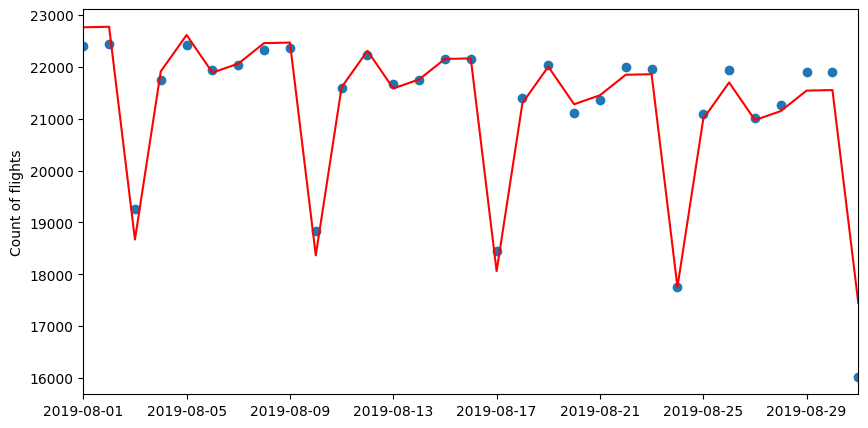

In [14]:
full_model, preds, resids = model_trend_seasonality(flights_per_day)

# Calculate the model performance statistics
mse = np.sum(resids**2,axis=0)/flights_per_day.shape[0]
r2 = 1 - np.sum((resids)**2)/np.sum((flights_per_day-np.mean(flights_per_day))**2)

# Display the model and performance metrics
print('The fitted model is:')
# Get the equation for the model
coef = full_model.coef_
intercept = full_model.intercept_

# Print out the equation
equation = 'y = {:.2f} + '.format(intercept) + ' + '.join(['{:.2f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print(equation)


print('\nThe simple linear model has R^2={:.3f} and MSE={:.3f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=dowmodel_encoded.index, y=dowmodel_encoded['Count'])
plt.plot(dowmodel_encoded.index, preds,color='red')
plt.xlim((dowmodel_encoded.index.min(),dowmodel_encoded.index.max()))
plt.ylabel('Count of flights')
plt.show()

## Model using autocorrelation
### Evaluating autocorrelation
We can use Pearson's correlation coefficient to evaluate the correlation of the variable's observations with previous time step observations (called lags) of the variable.  Pearson's correlation coefficient ranges between -1 (complete negative correlation) and +1 (complete positive correlation), with a value of 0 indicating no correlation. The correlation of the observations with past time steps is called autocorrelation.

The statsmodels library gives us a handy tool to plot the autocorrelation for a pandas series.  The shaded region in the plot below indicates the 95% confidence interval, meaning if a correlation is above or below this, we can interpret it to be statistically significant.

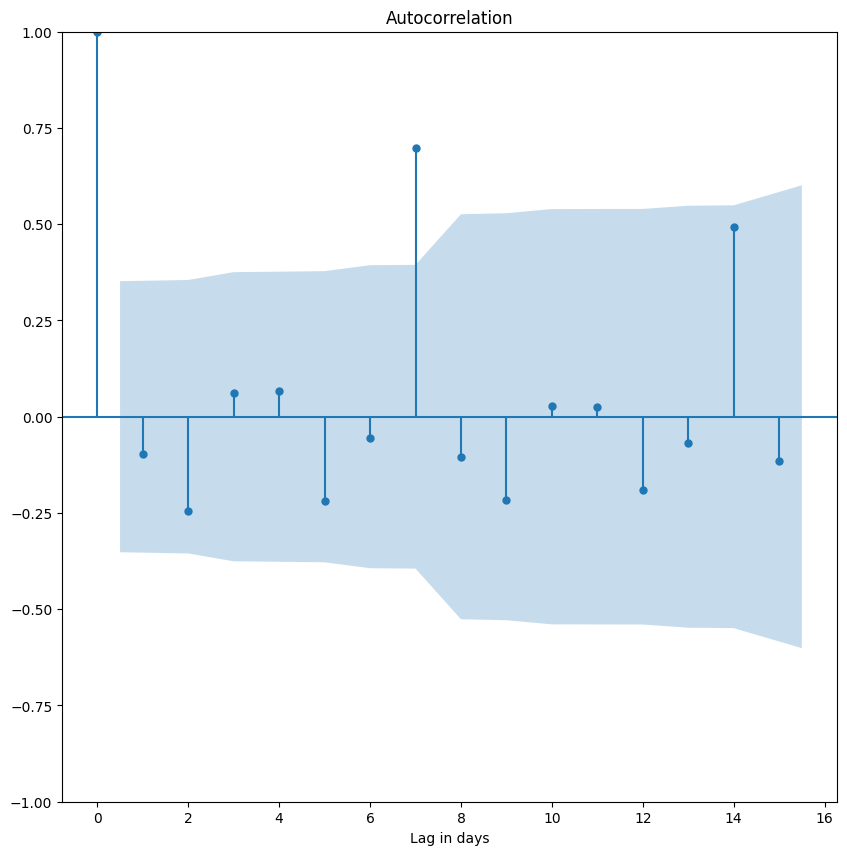

In [15]:
# Display autocorrelation plot of flights_per_day over the time period
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(flights_per_day)
plt.xlabel('Lag in days')
plt.show()

As we can see above, there is very little correlation of flight count on a particular day to the flight count on the previous day (lag=1).  Thus, the number of flights per day is unlikely to be a Markov process (where the autocorrelation to the observation at time t-1 (lag=1) explains all autocorrelation in the data).

However, there is strong correlation of flight count to the count one week earlier (lag=7).  This is logical because we would expect the number of flights on each day of the week to be different, although similar to the count on the same day in prior weeks.  This is also consistent with the seasonable component of the time series decomposition we did above, where we found that the data shows a strong seasonal/cyclical component with a period=7.

Let's build a function that helps us evaluate a model using autocorrelation. Complete the below function `autocorr_model()` which takes as inputs the DataFrame of flight counts and a number of days to model the autocorrelation.  The function should create a feature representing the flight count at the number of days lag specified as an input, build a linear regression model, and then generate and return the model, its predictions for each day, and the residuals.

In [16]:
def autocorr_model(flights_df,days_lag):

    ### BEGIN SOLUTION ###

    # Add column containing the value at t-1
    flights_df['PreviousCount'] = flights_df['Count'].shift(days_lag,freq='D') #Add new column containing count at days_lag
    flights_df = flights_df.iloc[days_lag:]

    # Create a single-variable linear regression
    model = LinearRegression()
    model.fit(X=flights_df['PreviousCount'].values.reshape(-1,1), y=flights_df['Count'])

    # Get in-sample predictions for the days in the month
    preds = model.predict(flights_df['PreviousCount'].values.reshape(-1,1))
    resids = flights_df['Count']-preds

    return model, preds, resids

    ### END SOLUTION ###

The fitted model is: y = -0.153x + 24485.213
The simple linear model has R^2=0.015 and MSE=2298349.56


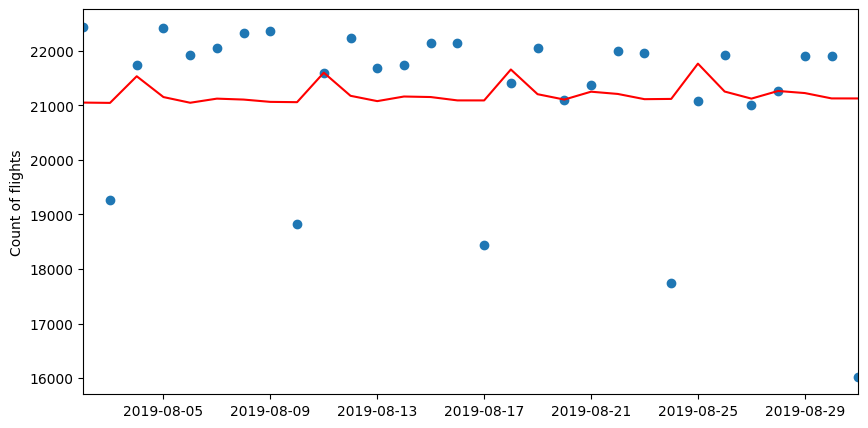

In [17]:
# Create a dataframe with the data formatted as we need it
flights_df = pd.DataFrame({'Count':flights_per_day})
days_lag = 1
model, preds, resids = autocorr_model(flights_df,days_lag)

# Display the model
print('The fitted model is: y = {:.3f}x + {:.3f}'.format(model.coef_[0], model.intercept_))

# Calculate and display the model performance statistics
mse = np.sum(resids**2,axis=0)/len(resids)
r2 = 1 - mse/np.var(flights_df['Count'][days_lag:])
print('The simple linear model has R^2={:.3f} and MSE={:.2f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=flights_df.index, y=flights_df['Count'])
plt.plot(flights_df.index[days_lag:], preds,color='red')
plt.xlim((flights_df.index[days_lag:].min(),flights_df.index[days_lag:].max()))
plt.ylabel('Count of flights')
plt.show()

As we would expect, the model produced by using only the value at time t-1 as an input is essentially garbage.  The reason for this is that there is no autocorrelation with the value at t-1 (lag-1).  Let's try again using the flight count 7 days prior as the feature, instead of yesterday's count. 

The fitted model is: y = 1.195x + -4461.182
The simple linear model has R^2=0.980 and MSE=46812.51


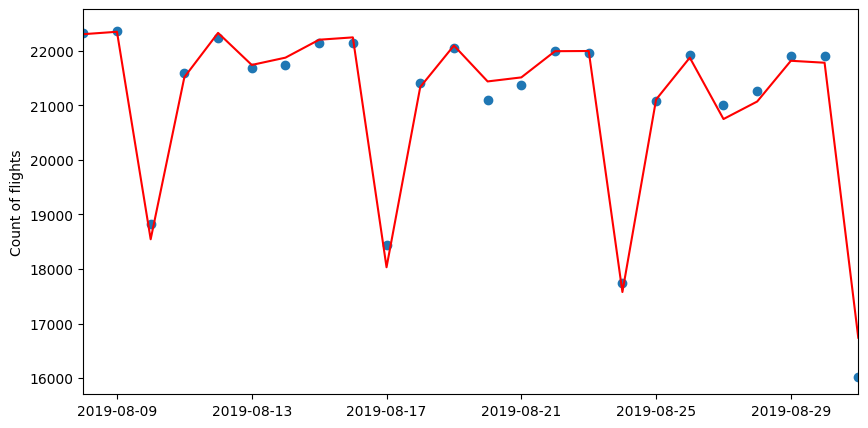

In [18]:
# Create a dataframe with the data formatted as we need it
flights_df = pd.DataFrame({'Count':flights_per_day})
days_lag = 7
model, preds, resids = autocorr_model(flights_df,days_lag)

# Display the model
print('The fitted model is: y = {:.3f}x + {:.3f}'.format(model.coef_[0], model.intercept_))

# Calculate and display the model performance statistics
mse = np.sum(resids**2,axis=0)/len(resids)
r2 = 1 - mse/np.var(flights_df['Count'])
print('The simple linear model has R^2={:.3f} and MSE={:.2f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,5))
plt.scatter(x=flights_df.index, y=flights_df['Count'])
plt.plot(flights_df.index[days_lag:], preds,color='red')
plt.xlim((flights_df.index[days_lag:].min(),flights_df.index.max()))
plt.ylabel('Count of flights')
plt.show()

## OPTIONAL: Time series forecasting with Prophet
Prophet is a open source time series forecasting tool from Facebook that uses a time series model where nonlinear trends are fit with yearly, weekly and daily seasonality plus holiday effects.  It breaks down time series data similar to our above example with statsmodels seasonal_decompose into trend and seasonal components, and then uses an additive or multiplicative model (as set by user) of the components to do forecasting.

First install prophet (https://facebook.github.io/prophet/docs/installation.html#python). The package was renamed from fbprophet to prophet:  
pip install prophet

In [20]:
from prophet import Prophet

In [21]:
# Prophet expects the data to be in a DataFrame 
# with columns "ds" (date in Pandas datetime) and "y" (values)
df = pd.DataFrame()
df['ds'] = flights_per_day.index
df['y'] = flights_per_day.values

In [22]:
# Create the Prophet time series model and fit to the data
model = Prophet(seasonality_mode='additive')
model.fit(df)

23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing


### Make an in-sample forecast

In [23]:
# Make an in-sample prediction for the dataset
future = pd.DataFrame(df['ds']) # Put in format needed
forecast_insample = model.predict(future) # Get the predictions for the week
forecast_insample.T # Display the transposed data for easier viewing

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
ds,2019-08-01 00:00:00,2019-08-02 00:00:00,2019-08-03 00:00:00,2019-08-04 00:00:00,2019-08-05 00:00:00,2019-08-06 00:00:00,2019-08-07 00:00:00,2019-08-08 00:00:00,2019-08-09 00:00:00,2019-08-10 00:00:00,...,2019-08-22 00:00:00,2019-08-23 00:00:00,2019-08-24 00:00:00,2019-08-25 00:00:00,2019-08-26 00:00:00,2019-08-27 00:00:00,2019-08-28 00:00:00,2019-08-29 00:00:00,2019-08-30 00:00:00,2019-08-31 00:00:00
trend,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689,21699.900001,21665.646311,21631.39262,21597.138901,21562.885178,...,21053.068301,20998.250578,20942.820015,20886.750532,20830.68105,20774.611567,20718.542084,20662.472601,20606.403119,20550.333636
yhat_lower,22306.904939,22300.133573,18205.754235,21422.751431,22167.220693,21430.483123,21620.045727,21986.258793,22060.40359,17962.847945,...,21481.66462,21492.370853,17315.234036,20567.84622,21272.226158,20502.924639,20657.565849,21066.165883,21064.683842,16943.016821
yhat_upper,23126.052555,23148.674433,19045.414017,22299.689467,23011.070122,22295.83156,22469.143312,22893.643498,22896.827235,18789.848274,...,22311.458756,22256.968204,18224.998277,21382.158219,22104.937668,21360.281371,21494.324846,21892.110668,21921.575791,17798.059716
trend_lower,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689,21699.900001,21665.646311,21631.39262,21597.138901,21562.885178,...,21053.068301,20998.250578,20942.820015,20886.750532,20830.68105,20774.611567,20718.542084,20662.472601,20606.403119,20550.333636
trend_upper,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689,21699.900001,21665.646311,21631.39262,21597.138901,21562.885178,...,21053.068301,20998.250578,20942.820015,20886.750532,20830.68105,20774.611567,20718.542084,20662.472601,20606.403119,20550.333636
additive_terms,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853,...,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853
additive_terms_lower,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853,...,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853
additive_terms_upper,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853,...,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853
weekly,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853,...,830.609868,883.426994,-3176.071853,91.676744,837.729993,157.350022,375.278232,830.609868,883.426994,-3176.071853


The above dataframe shows us a wealth of information about the predictions that Prophet made for the week.  'yhat' represents the prediction, and there is an upper and lower bount 'yhat_lower' and 'yhat_upper'.  We can see the trend component and the weekly seasonal component, which added together form our prediction (since we used an additive model rather than a multiplicative model).

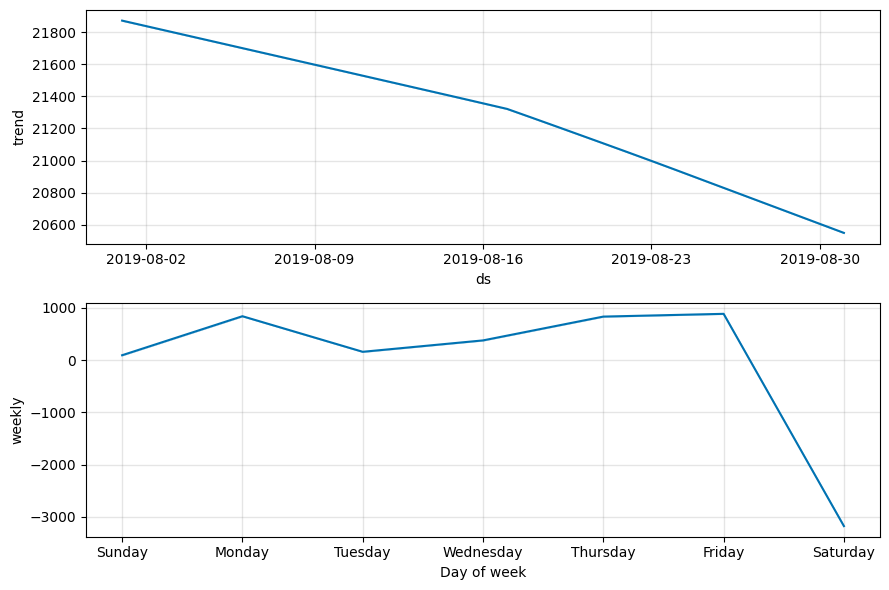

In [24]:
# Plot the trend and seasonal components of the forecast
model.plot_components(forecast_insample)
plt.show()

In [25]:
# Calculate performance metrics on our model
eval_df = pd.DataFrame({'Count':flights_per_day.values,'Preds':forecast_insample['yhat']})
eval_df['resids'] = eval_df['Count'] - eval_df['Preds']
mse = np.sum(eval_df['resids']**2,axis=0)/eval_df.shape[0]
r2 = 1 - mse/np.var(eval_df['Count']) # Alternative way to calculate r2
print('The Prophet time series model has R^2={:.2f} and MSE={:.2f}'.format(r2,mse))

The Prophet time series model has R^2=0.95 and MSE=107254.59


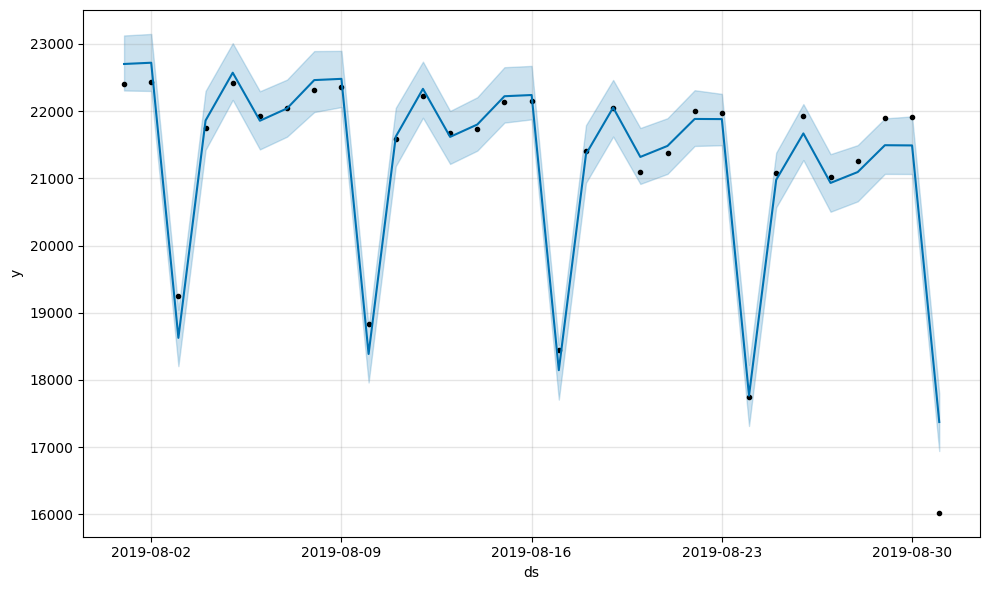

In [26]:
# Plot the in-sample prediction
model.plot(forecast_insample)
plt.show()

The above plot shows the training data that we provided to the model represented as black dots, and the forecast as a blue line with upper and lower bounds in the shaded area. We can see that the model does a reasonable job predicting the in-sample values.

### Make a future forecast

In [27]:
# Use Prophet helper function to create dataframe with dates for next 14 days after the training period
future = model.make_future_dataframe(periods=14) 

# Generate a forecast for the future 14 days
forecast = model.predict(future)
forecast.head().T

,0,1,2,3,4
ds,2019-08-01 00:00:00,2019-08-02 00:00:00,2019-08-03 00:00:00,2019-08-04 00:00:00,2019-08-05 00:00:00
trend,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689
yhat_lower,22274.909538,22302.111697,18172.924134,21400.550334,22180.888582
yhat_upper,23145.4119,23156.240384,19031.684272,22274.22167,23019.275721
trend_lower,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689
trend_upper,21871.16844,21836.914752,21802.661064,21768.407376,21734.153689
additive_terms,830.609868,883.426994,-3176.071853,91.676744,837.729993
additive_terms_lower,830.609868,883.426994,-3176.071853,91.676744,837.729993
additive_terms_upper,830.609868,883.426994,-3176.071853,91.676744,837.729993
weekly,830.609868,883.426994,-3176.071853,91.676744,837.729993


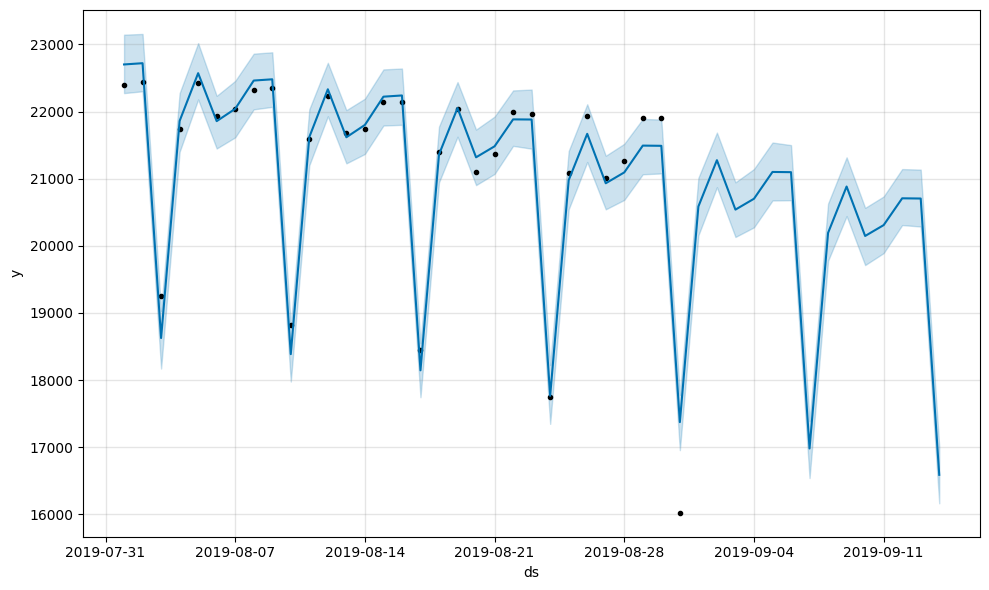

In [28]:
# Display the forecast and the training datapoints
model.plot(forecast)
plt.show()

Again, the training data from our dataset are shown with black dots, and the forecast is shown in blue, now including the forecast for the next two weeks.